In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from glob import glob
from xgcm import Grid

%matplotlib inline

## load avg files

In [5]:
chunks = {'ocean_time':1}
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_0[1-4]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_avg_01*.nc')

ds = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

## Set up metrics for grid aware curl calculation 

In [6]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

In [7]:
Udx = ds.bustr * grid.get_metric(ds.bustr, "X")
Vdy = ds.bvstr * grid.get_metric(ds.bvstr, "Y")

### Calculate derivatives in x and y

In [8]:
U_der = -grid.diff(Udx, "X", boundary="extend")
V_der = grid.diff(Vdy, "X", boundary="extend")

### Interp everything onto the same points

In [9]:
U_der = grid.interp(U_der,"X",boundary="extend")
U_der = grid.interp(U_der,"Y",boundary="extend")

### Weight by area

In [10]:
der = U_der + V_der
area = grid.get_metric(der, "XY")
curlz = der / area

### put onto tracer grid for plotting

In [11]:
bot_stress_curl = grid.interp(curlz,'X',boundary='extend')
bot_stress_curl = grid.interp(bot_stress_curl,'Y',boundary='extend')

## Plot

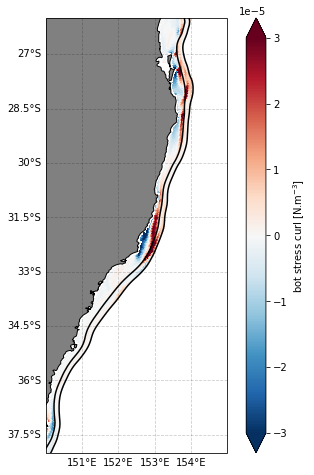

In [17]:
fig = plt.figure(figsize=(15,8))
#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.set_extent([150,155,-26,-38])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=bot_stress_curl.where(ds.h<1000).isel(ocean_time=1).plot(x='lon_rho', y='lat_rho', vmin=-3e-5,cbar_kwargs={'label': 'bot stress curl [N.m$^{-3}$]'})
ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

plt.savefig('bot_stress_curl_half_tseries.png',dpi=300)